In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc
from tabulate import tabulate

In [ ]:
# Veri kümesi
df = pd.read_csv("/content/drive/MyDrive/Colab çalışma/SDN_Dataset_Openflow.csv")

In [ ]:
print(df)

         dt  switch  pktcount  bytecount   dur   dur_nsec       tot_dur  \
0     24810       2       361      35378   373  153000000  3.730000e+11   
1     11379       2     48866    3225312   154  351000000  1.540000e+11   
2     30973       1     98329    6490034   310  614000000  3.110000e+11   
3     30252       2       507      49686   519  936000000  5.200000e+11   
4     26987       2     46463   48229422   201  139000000  2.010000e+11   
...     ...     ...       ...        ...   ...        ...           ...   
2285   2578       1     16827   17937582    37  321000000  3.732100e+10   
2286   7837       2     77102    5089372   252  259000000  2.520000e+11   
2287  28368       2    131732  135629736  1581  421000000  1.580000e+12   
2288  41163       1    115809  128999930   263  393000000  2.630000e+11   
2289  27317       1       518      50764   531  204000000  5.310000e+11   

      flows  packetins  pktperflow  ...  dst_10.0.0.4  dst_10.0.0.5  \
0         5       2997      

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dt             2290 non-null   int64  
 1   switch         2290 non-null   int64  
 2   pktcount       2290 non-null   int64  
 3   bytecount      2290 non-null   int64  
 4   dur            2290 non-null   int64  
 5   dur_nsec       2290 non-null   int64  
 6   tot_dur        2290 non-null   float64
 7   flows          2290 non-null   int64  
 8   packetins      2290 non-null   int64  
 9   pktperflow     2290 non-null   int64  
 10  byteperflow    2290 non-null   int64  
 11  pktrate        2290 non-null   int64  
 12  Pairflow       2290 non-null   int64  
 13  port_no        2290 non-null   int64  
 14  tx_bytes       2290 non-null   int64  
 15  rx_bytes       2290 non-null   int64  
 16  tx_kbps        2290 non-null   int64  
 17  rx_kbps        2273 non-null   float64
 18  tot_kbps

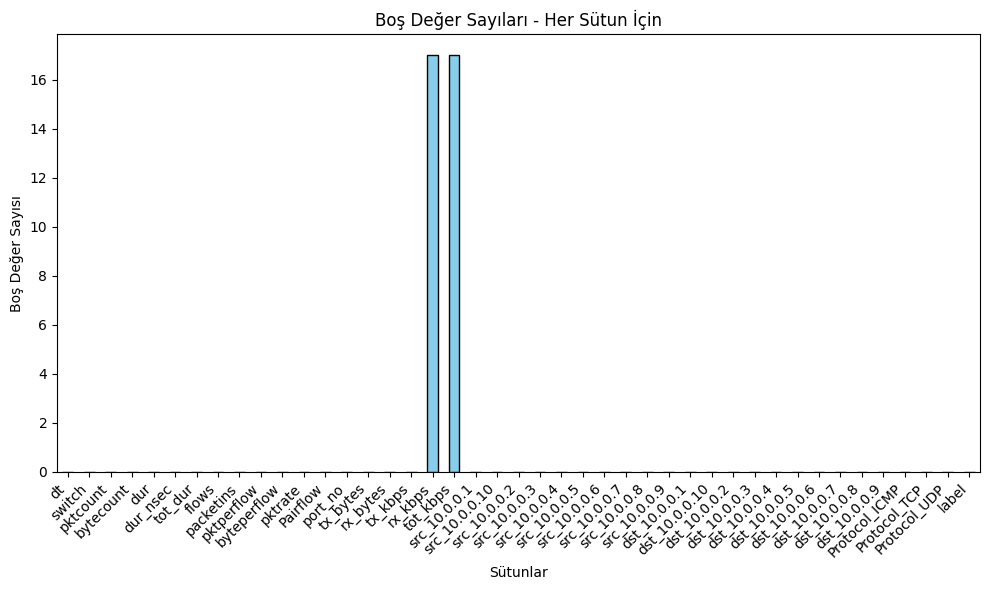

In [ ]:
# NaN değererin sayısı sütun bazlı
missing_values = df.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Boş Değer Sayıları - Her Sütun İçin')
plt.xlabel('Sütunlar')
plt.ylabel('Boş Değer Sayısı')
plt.xticks(rotation=45, ha='right')  # Sütun etiketlerini döndürme
plt.tight_layout()
plt.show()

In [ ]:
# NaN değerleri 0.0 ile değiştir
df = df.fillna(0)

In [ ]:
print(df.shape)

(2290, 43)


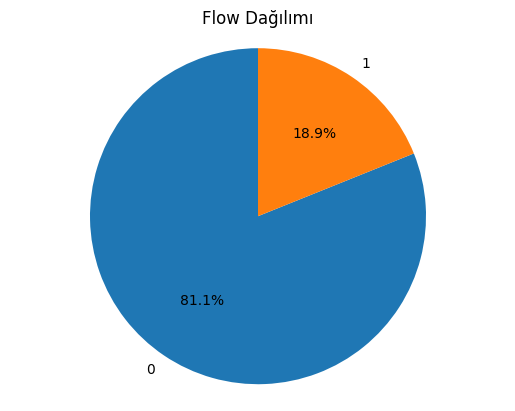

In [ ]:
# Attack flow ve Normal flow sütununun değerine göre sayıları
flow_counts = df["label"].value_counts()
# Normal flow = 0  , DDOs Flow = 1
plt.pie(flow_counts, labels=flow_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Flow Dağılımı")
plt.show()

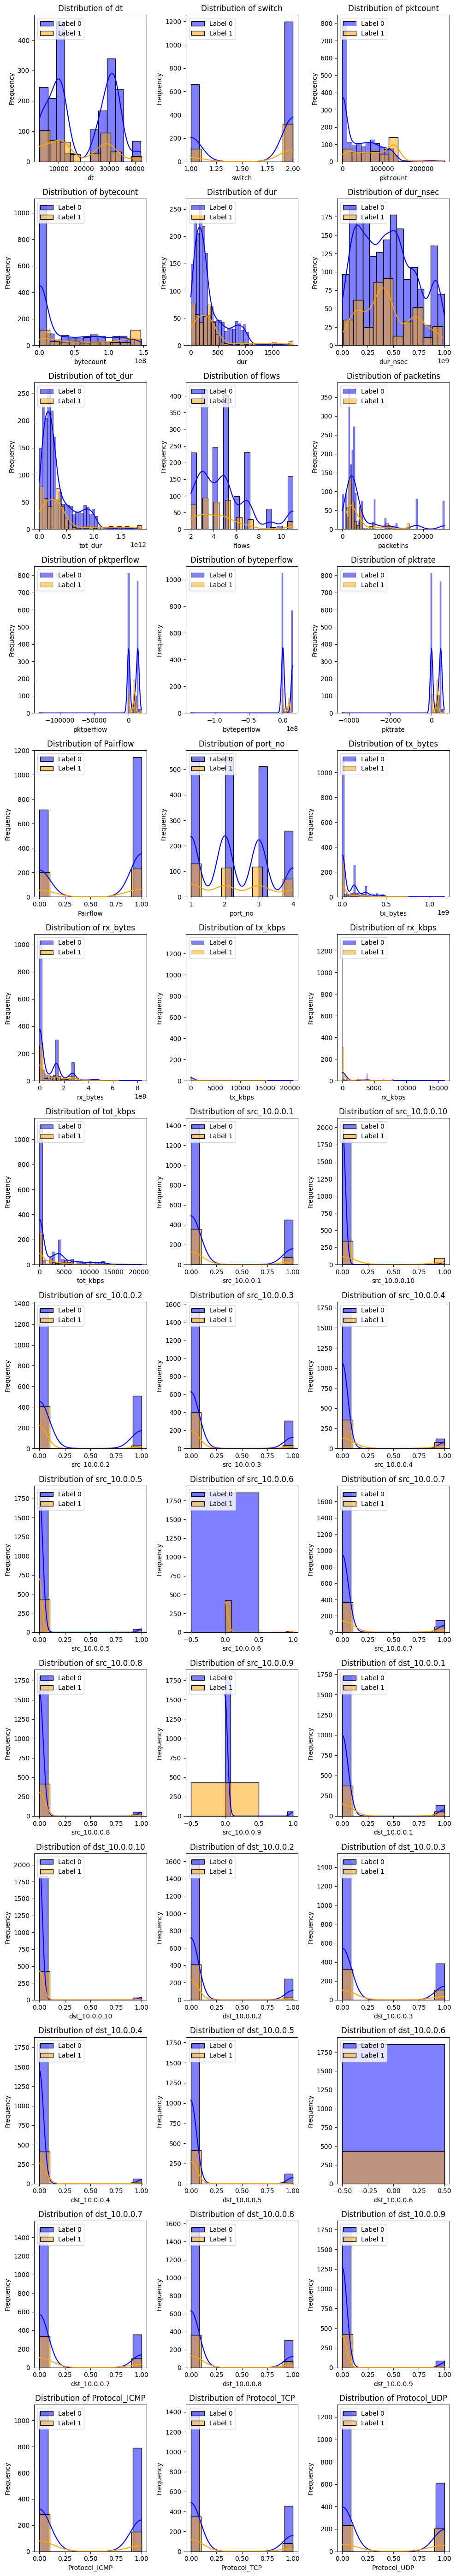

In [ ]:
def plot_feature_distributions(df, label_column, n_cols=3):
  feature_names = df.columns[:-1]
  n_rows = (len(feature_names) + n_cols - 1) // n_cols  # Calculate number of rows

  # Create the figure and subplots
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))

  # Iterate through features and plot distributions
  for i, feature in enumerate(feature_names):
    row, col = divmod(i, n_cols)
    sns.histplot(df[df[label_column] == 0][feature], label='Label 0', kde=True, color='blue', ax=axes[row, col])
    sns.histplot(df[df[label_column] == 1][feature], label='Label 1', kde=True, color='orange', ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend(loc='upper left')

  # Hide unnecessary subplots if there are more features than fit the grid
  for i in range(len(feature_names), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

  plt.tight_layout()
  plt.show()

# Call the function
plot_feature_distributions(df.copy(), label_column="label")

In [ ]:
X = df.iloc[:, :-1]
y = df['label']

In [ ]:
#  Veriyi eğitim ve test setlerine bölelim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train setini tekrar train ve validation setlerine bölelim
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
# Veriyi ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Modelleri tanımla
models = [
    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=5)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Support Vector Machine", SVC(kernel="linear", C=1.0)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Naive Bayes", GaussianNB())
]

In [ ]:
# Model performanslarını Validation
results = {"Model": [], "F1 Score": [], "Precision": [], "Recall": [], "Accuracy": []}

In [ ]:
#  Model performanslarını test
test_results = {"Model": [], "F1 Score": [], "Precision": [], "Recall": [], "Accuracy": [], "Confusion Matrix": []}

## Validation Set değerlendirmesi

In [ ]:
for model_name, model in models:
    model.fit(X_train_scaled, y_train)
    #val
    y_pred = model.predict(X_val_scaled)
    # test
    y_pred_test = model.predict(X_test_scaled)
    #val
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)


    results["Model"].append(model_name)
    results["F1 Score"].append(f1)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["Accuracy"].append(accuracy)

    #test
    f1_test = f1_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    cm = confusion_matrix(y_test, y_pred_test)

    test_results["Model"].append(model_name)
    test_results["F1 Score"].append(f1_test)
    test_results["Precision"].append(precision_test)
    test_results["Recall"].append(recall_test)
    test_results["Accuracy"].append(accuracy_test)
    test_results["Confusion Matrix"].append(cm)

In [ ]:
# Sonuçları DataFrame'e çevirme
results_df = pd.DataFrame(results)

In [ ]:
# Her bir modelin validation setindeki performanslarını yazdırma
for index, row in results_df.iterrows():
    print(f"{row['Model']} Modeli validation Seti Performansı:")
    print(f"F1 Score: {row['F1 Score']:.4f}")
    print(f"Precision: {row['Precision']:.4f}")
    print(f"Recall: {row['Recall']:.4f}")
    print(f"Accuracy: {row['Accuracy']:.4f}")
    print("\n" + "="*50 + "\n")

K-Nearest Neighbors Modeli validation Seti Performansı:
F1 Score: 0.8000
Precision: 0.9310
Recall: 0.7013
Accuracy: 0.9410


Random Forest Modeli validation Seti Performansı:
F1 Score: 0.9737
Precision: 0.9867
Recall: 0.9610
Accuracy: 0.9913


Gradient Boosting Modeli validation Seti Performansı:
F1 Score: 0.9744
Precision: 0.9620
Recall: 0.9870
Accuracy: 0.9913


Logistic Regression Modeli validation Seti Performansı:
F1 Score: 0.7121
Precision: 0.8545
Recall: 0.6104
Accuracy: 0.9170


Support Vector Machine Modeli validation Seti Performansı:
F1 Score: 0.6772
Precision: 0.8600
Recall: 0.5584
Accuracy: 0.9105


Decision Tree Modeli validation Seti Performansı:
F1 Score: 0.9481
Precision: 0.9481
Recall: 0.9481
Accuracy: 0.9825


Naive Bayes Modeli validation Seti Performansı:
F1 Score: 0.5000
Precision: 0.4016
Recall: 0.6623
Accuracy: 0.7773




## Test seti değerlendirmesi

In [ ]:
# Test seti üzerinde performansları DataFrame'e çevirme
test_results_df = pd.DataFrame(test_results)

In [ ]:
# Her bir modelin test setindeki performanslarını yazdırma
for index, row in test_results_df.iterrows():
    print(f"{row['Model']} Modeli Test Seti Performansı:")
    print(f"F1 Score: {row['F1 Score']:.4f}")
    print(f"Precision: {row['Precision']:.4f}")
    print(f"Recall: {row['Recall']:.4f}")
    print(f"Accuracy: {row['Accuracy']:.4f}")
    print("\n" + "="*50 + "\n")

K-Nearest Neighbors Modeli Test Seti Performansı:
F1 Score: 0.7451
Precision: 0.9344
Recall: 0.6196
Accuracy: 0.9148


Random Forest Modeli Test Seti Performansı:
F1 Score: 0.9492
Precision: 0.9882
Recall: 0.9130
Accuracy: 0.9803


Gradient Boosting Modeli Test Seti Performansı:
F1 Score: 0.9730
Precision: 0.9677
Recall: 0.9783
Accuracy: 0.9891


Logistic Regression Modeli Test Seti Performansı:
F1 Score: 0.6259
Precision: 0.8364
Recall: 0.5000
Accuracy: 0.8799


Support Vector Machine Modeli Test Seti Performansı:
F1 Score: 0.5867
Precision: 0.7586
Recall: 0.4783
Accuracy: 0.8646


Decision Tree Modeli Test Seti Performansı:
F1 Score: 0.9560
Precision: 0.9667
Recall: 0.9457
Accuracy: 0.9825


Naive Bayes Modeli Test Seti Performansı:
F1 Score: 0.5217
Precision: 0.4696
Recall: 0.5870
Accuracy: 0.7838




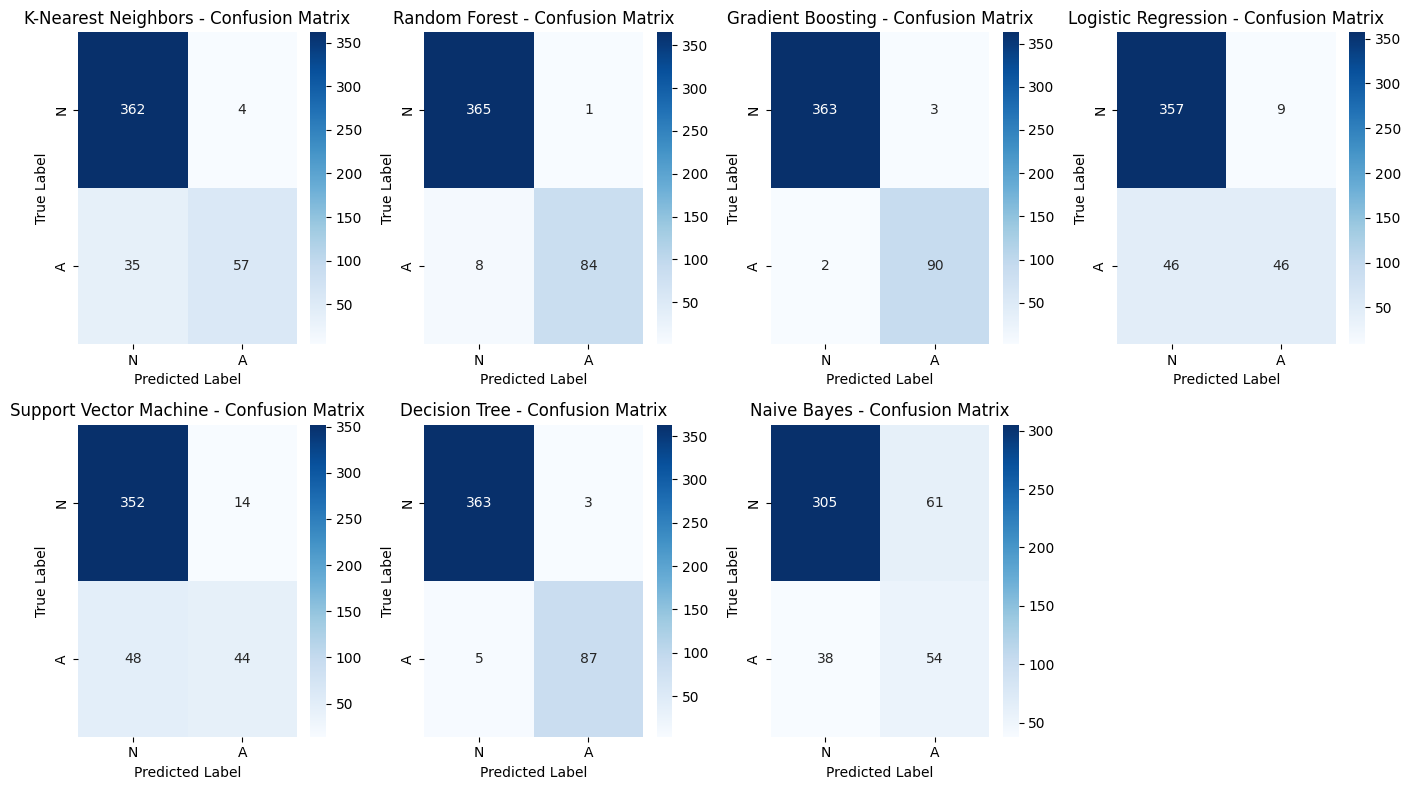

In [ ]:
plt.figure(figsize=(14, 8))
for i, model_name in enumerate(test_results_df["Model"]):
    plt.subplot(2, 4, i + 1)
    sns.heatmap(test_results_df.loc[i, "Confusion Matrix"], annot=True, fmt="d", cmap="Blues",
                xticklabels=["N", "A"], yticklabels=["N", "A"])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

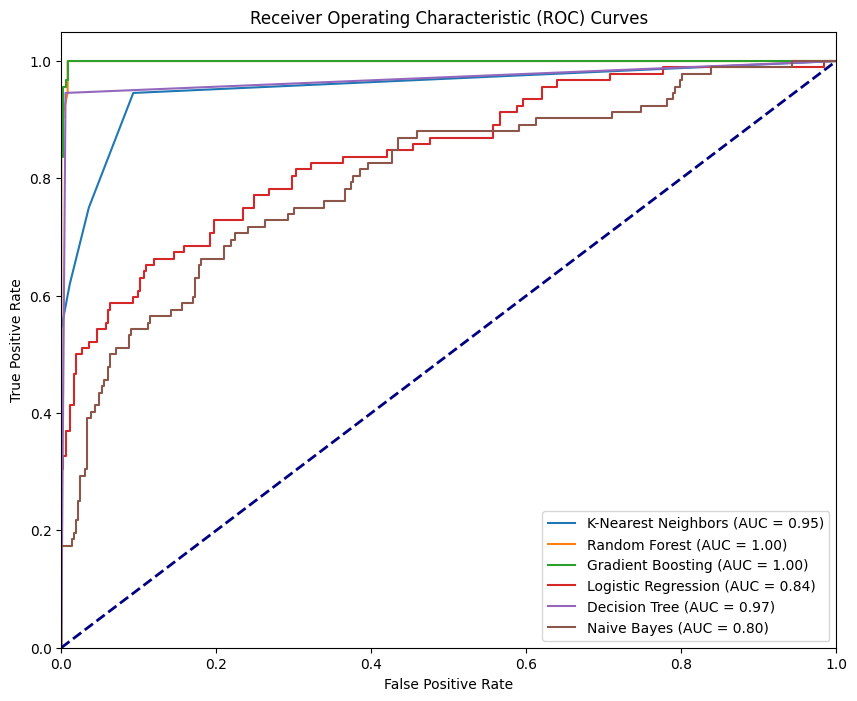

In [ ]:
plt.figure(figsize=(10, 8))
for model_name, model in models:
    if hasattr(model, "predict_proba"):  # Eğer model olasılıkları tahmin edebiliyorsa
        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

In [ ]:
table = tabulate(test_results_df, headers='keys', tablefmt='fancy_grid', showindex=False)
print(table)

╒════════════════════════╤════════════╤═════════════╤══════════╤════════════╤════════════════════╕
│ Model                  │   F1 Score │   Precision │   Recall │   Accuracy │ Confusion Matrix   │
╞════════════════════════╪════════════╪═════════════╪══════════╪════════════╪════════════════════╡
│ K-Nearest Neighbors    │   0.745098 │    0.934426 │ 0.619565 │   0.914847 │ [[362   4]         │
│                        │            │             │          │            │  [ 35  57]]        │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼────────────────────┤
│ Random Forest          │   0.949153 │    0.988235 │ 0.913043 │   0.980349 │ [[365   1]         │
│                        │            │             │          │            │  [  8  84]]        │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼────────────────────┤
│ Gradient Boosting      │   0.972973 │    0.967742 │ 0.978261 │   0.989083 │ [[363   3]         │
│         

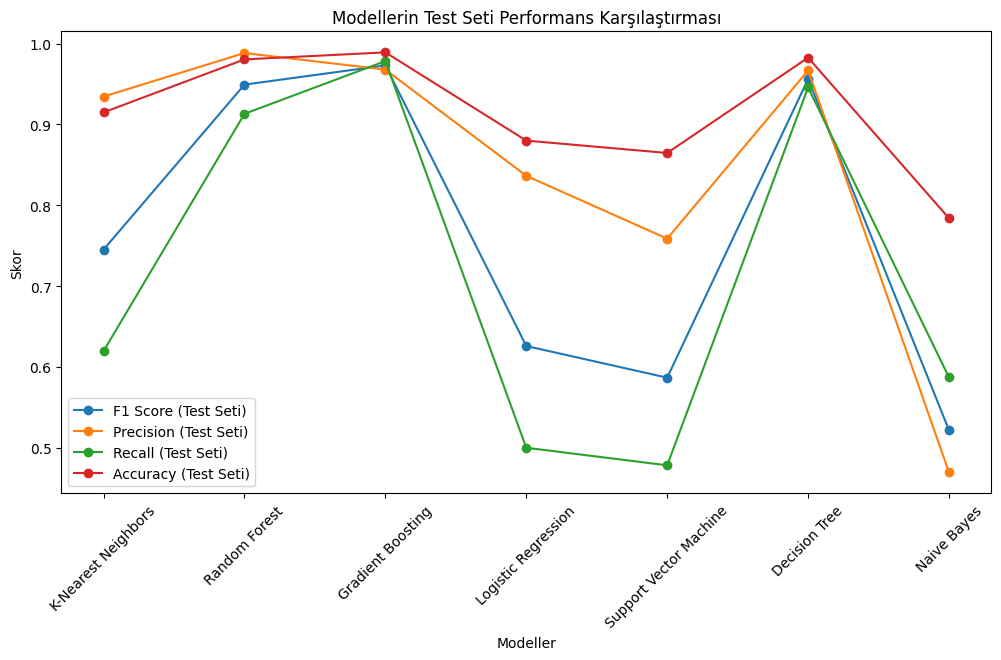

In [ ]:
# Her bir modelin test setindeki performanslarını görselleştirme
plt.figure(figsize=(12, 6))
for metric in ["F1 Score", "Precision", "Recall", "Accuracy"]:
    plt.plot(test_results_df["Model"], test_results_df[metric], marker='o', label=metric + ' (Test Seti)')

plt.title('Modellerin Test Seti Performans Karşılaştırması')
plt.xlabel('Modeller')
plt.ylabel('Skor')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Modellerin en iyi olduğu metrikleri yazdırma
best_f1_model = test_results_df.loc[test_results_df["F1 Score"].idxmax()]["Model"]
best_precision_model = test_results_df.loc[test_results_df["Precision"].idxmax()]["Model"]
best_recall_model = test_results_df.loc[test_results_df["Recall"].idxmax()]["Model"]
best_accuracy_model = test_results_df.loc[test_results_df["Accuracy"].idxmax()]["Model"]

print(f"En iyi F1 Score Modeli: {best_f1_model}")
print(f"En iyi Precision Modeli: {best_precision_model}")
print(f"En iyi Recall Modeli: {best_recall_model}")
print(f"En iyi Accuracy Modeli: {best_accuracy_model}")

En iyi F1 Score Modeli: Gradient Boosting
En iyi Precision Modeli: Random Forest
En iyi Recall Modeli: Gradient Boosting
En iyi Accuracy Modeli: Gradient Boosting
